In [115]:
%matplotlib inline
import pandas as pd
import os
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [59]:
import numpy as np
import datetime as dt

import scipy.stats as stats

In [47]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [45]:
# Convert csv file into Pandas DataFrame
measurement_df = pd.read_csv(f"{os.getcwd()}/hawaii_measurements.csv", parse_dates = [1])

measurement_df



,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [44]:
# Calculate average June temperature for all stations

june_ave = measurement_df[measurement_df["date"].dt.month == 6].tobs.mean()

june_ave



74.94411764705882

In [43]:
# Calculate average December temperature for all stations

dec_ave = measurement_df[measurement_df["date"].dt.month == 12].tobs.mean()

dec_ave



71.04152933421226

In [37]:
# Use the t-test to determine whether the difference in the means 
# between two samples, if any, is statiscally significant

data_june = measurement_df[measurement_df["date"].dt.month == 6]["tobs"]

data_dec = measurement_df[measurement_df["date"].dt.month == 12]["tobs"]


stats.ttest_ind(data_june, data_dec, equal_var=False)


Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

### Conclusion


- The p-value is 0.419, which is much greater than the significance level (alpha = 0.05), so we are not going to reject the null hypothesis. Having said that, the means from both groups are almost equal as calculated above given that they have different sample size.


- Paired t-test was employed to approach the above result since it compared study subjects at two different times. 

In [11]:
# Convert csv file into Pandas Dataframe

stations_df = pd.read_csv(f"{os.getcwd()}/hawaii_stations.csv")

stations_df

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [48]:
# Create engine 

engine = create_engine(f"sqlite:///{os.getcwd()}/hawaii.sqlite")

In [49]:
# Reflecting an existing database into a new model

Base = automap_base()

In [50]:
# Reflecting the tables

Base.prepare(engine, reflect = True)

In [51]:
# Save references to the table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [56]:
# Create a session from Python to DB

session = Session(bind = engine)

In [106]:
# Define a func called "calc_temps" and return the min, max, and avg 
# temperature for a range of dates

def calc_temps(start_date, end_date):
    
    # Convert start date to matching dates from the previous year
    convert_start = dt.datetime.strptime(start_date, "%Y-%m-%d")
    start_date_year_ago = dt.datetime(year = convert_start.year - 1, month = convert_start.month, day = convert_start.day)
    start_date = start_date_year_ago.strftime("%Y-%m-%d")

    
    # Convert end date to matching dates from the previous year
    convert_end = dt.datetime.strptime(end_date, "%Y-%m-%d")
    end_date_year_ago = dt.datetime(year = convert_end.year - 1, month = convert_end.month, day = convert_end.day)
    end_date = end_date_year_ago.strftime("%Y-%m-%d")
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                        filter(Measurement.date >= start_date).\
                        filter(Measurement.date <= end_date).all()
                        
                        
                        
                        
                        

In [109]:
# Test function

print(calc_temps("2012-02-28", "2012-03-05"))


[(61.0, 69.75510204081633, 75.0)]


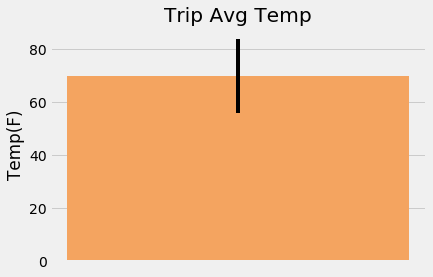

In [144]:
# Plot the results from the previous query as a bar chart

results = calc_temps("2012-02-28", "2012-03-05")

plt.bar(x = 0, height = results[0][1], yerr = results[0][2] - results[0][0], color = "sandybrown")
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.xticks([])
plt.show()



In [160]:
# Define a function to calculate the rainfall per weather station using
# the previous year's matching dates

def daily_normals(date):

    # Create a query that will calculate the daily normals
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()



In [186]:
# Create a list of date in the format of %m-%d
# Use the daily_normals func to calculate the normals for each date
# Append the results to a list

list_of_dates = ["2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05", "2020-01-06", "2020-01-07"]

min_temp = []
avg_temp = []
max_temp = []

for date in list_of_dates:
    results = daily_normals(date[-5:])
    for record in results:
        min_temp.append(results[0][0])
        avg_temp.append(results[0][1])
        max_temp.append(results[0][2])

        


In [182]:
# Load the list of daily normals into a DataFrame 
# and set the index equal to the date

df = pd.DataFrame({"Date": list_of_dates, "tmin": min_temp, "tavg": avg_temp, "tmax": max_temp})

df.set_index("Date", inplace = True)

df

,tmin,tavg,tmax
Date,,,
2020-01-01,62.0,69.153846,77.0
2020-01-02,60.0,69.396226,77.0
2020-01-03,62.0,68.909091,77.0
2020-01-04,58.0,70.000000,76.0
2020-01-05,56.0,67.964286,76.0
2020-01-06,61.0,68.964912,76.0
2020-01-07,57.0,68.543860,76.0


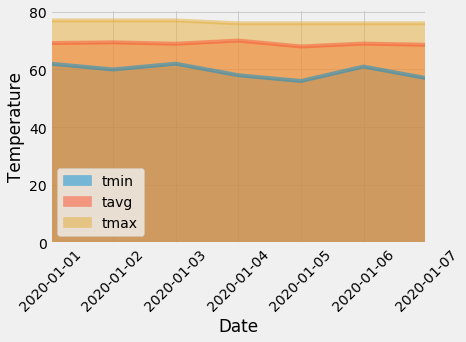

In [185]:
# Use Pandas to plot an area plot for the daily normals

df.plot.area(stacked = False, rot = 45)
plt.ylabel("Temperature")
plt.show()